In [0]:
%matplotlib inline
%tensorflow_version 2.x

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def spectrogram(xs):
  return signal.spectrogram(xs, 256, window=('hann'), nperseg=256, nfft=256, noverlap=200, mode='complex')

def plot_history(history):
  loss = history.history['loss']
  epochs = range(1, len(loss) + 1)

  plt.plot(epochs, loss, 'g-', label='Training loss')
  plt.title('Training loss')
  plt.legend()
  plt.show()


TensorFlow 2.x selected.


# Build Training Data

In [0]:
def build_training_data(batch_size, sample_size):
  xs = np.random.randn(batch_size, sample_size)
  f, t, ys = spectrogram(xs)

  (num_rows, num_cols) = (ys.shape[1], ys.shape[2])
  print(ys.shape)

  ys = ys.reshape(batch_size, num_rows * num_cols)
  Ys = np.hstack([ys.real, ys.imag])
  return (xs, Ys, num_rows, num_cols)

# Build Model

In [0]:
import tensorflow as tf

size = 2048
N = 15000

(xs, ys, rows, cols) = build_training_data(N, size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(rows * cols * 2, input_dim=size, use_bias=False)
])
model.summary()

optimizer = tf.keras.optimizers.Adam(amsgrad=True)
model.compile(loss='mean_squared_error', optimizer=optimizer)

(15000, 129, 33)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8514)              17436672  
Total params: 17,436,672
Trainable params: 17,436,672
Non-trainable params: 0
_________________________________________________________________


# Train Model

In [0]:
history = model.fit(xs, ys, epochs=10, batch_size=256)
plot_history(history)

Train on 15000 samples
Epoch 1/10
15000/15000 [==============================] - 162s 11ms/sample - loss: 0.0836
Epoch 2/10
11520/15000 [======================>.......] - ETA: 37s - loss: 0.0037

KeyboardInterrupt: ignored

(15000, 129, 33)
Train on 15000 samples
Epoch 1/10
15000/15000 [==============================] - 22s 1ms/sample - loss: 2.9846e-16
Epoch 2/10
15000/15000 [==============================] - 22s 1ms/sample - loss: 2.9056e-16
Epoch 3/10
15000/15000 [==============================] - 22s 1ms/sample - loss: 2.9133e-16
Epoch 4/10
15000/15000 [==============================] - 22s 1ms/sample - loss: 2.9391e-16
Epoch 5/10
15000/15000 [==============================] - 22s 1ms/sample - loss: 2.9596e-16
Epoch 6/10
15000/15000 [==============================] - 22s 1ms/sample - loss: 2.9820e-16
Epoch 7/10
15000/15000 [==============================] - 22s 1ms/sample - loss: 3.0098e-16
Epoch 8/10
15000/15000 [==============================] - 22s 1ms/sample - loss: 3.0327e-16
Epoch 9/10
15000/15000 [==============================] - 22s 1ms/sample - loss: 3.0565e-16
Epoch 10/10
15000/15000 [==============================] - 22s 1ms/sample - loss: 3.0703e-16


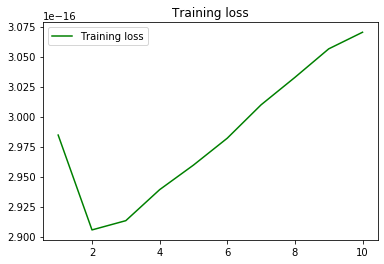

In [0]:
# Train a bit more, with new data
(xs, ys, rows, cols) = build_training_data(N, size)
new_history = model.fit(xs, ys, epochs=10, batch_size=256)
plot_history(new_history)

# Examine Model

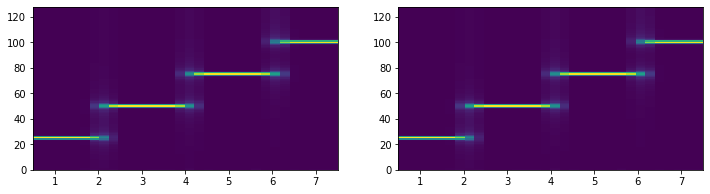

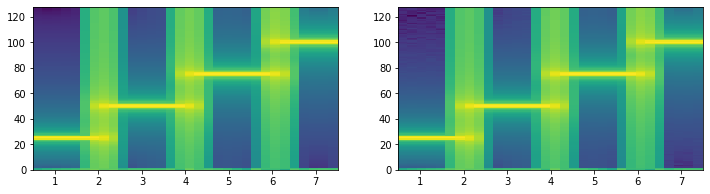

In [0]:
def make_wave():
  # Create four evenly-spaced tones
  waves = []
  hz = 0
  for i in range(0, size, 512):
    hz = hz + 50
    waves.append(np.sin(np.linspace(0, 2 * np.pi * hz, 512)))
  return np.hstack(waves)

wave = make_wave()

# Calculate spectrogram using math
f, t, wave_sxx = spectrogram(wave)
wave_sxx_graph = np.absolute(wave_sxx)

# Calculate spectrogram using neural network
nn_sxx = model.predict(np.reshape(wave, (1, size)))
nn_sxx_graph = np.reshape(np.absolute(nn_sxx[0][rows * cols:] + 1j * nn_sxx[0][:rows * cols]), (rows, cols))

# Plot spectrograms side-by-side
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, f, wave_sxx_graph)
plt.subplot(1, 2, 2)
plt.pcolormesh(t, f, nn_sxx_graph)
plt.show()

# Plot log spectrograms side-by-side
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.pcolormesh(t, f, np.log(wave_sxx_graph))
plt.subplot(1, 2, 2)
plt.pcolormesh(t, f, np.log(nn_sxx_graph))
plt.show()

In [0]:
# Show error statistics
total_error = np.sum(wave_sxx_graph - nn_sxx_graph)
print(total_error)
mae = total_error / len(wave_sxx_graph)
print(mae)
print(np.allclose(wave_sxx_graph, nn_sxx_graph, atol=1e-07))

-6.665448066796888e-07
-5.167014005268905e-09
True


In [0]:
weights_sxx = model.get_weights()[0]
print(weights_sxx.shape)
weights_sxx = np.reshape(weights_sxx, (size, rows * 2, cols))
print(weights_sxx.shape)
weights_sxx = np.moveaxis(weights_sxx, (0,1,2), (2,1,0))
print(weights_sxx.shape)

(2048, 8514)
(2048, 258, 33)
(33, 258, 2048)


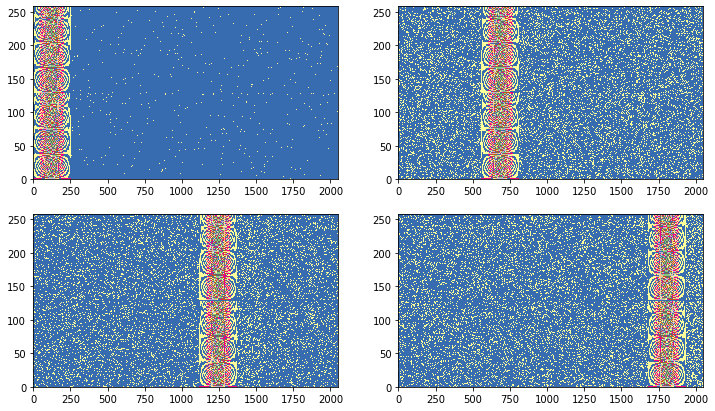

In [0]:
#plt.figure(figsize=(10,10))
#plt.pcolormesh(np.expand_dims(np.dot(weights_sxx[20], wave), 0), cmap="Greys")
#plt.show()

plt.figure(figsize=(12, 7))
plt.subplot(2, 2, 1)
plt.pcolormesh(weights_sxx[0], cmap="Accent")
plt.subplot(2, 2, 2)
plt.pcolormesh(weights_sxx[10], cmap="Accent")
plt.subplot(2, 2, 3)
plt.pcolormesh(weights_sxx[20], cmap="Accent")
plt.subplot(2, 2, 4)
plt.pcolormesh(weights_sxx[30], cmap="Accent")
plt.show()

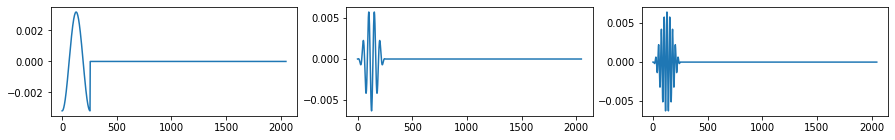

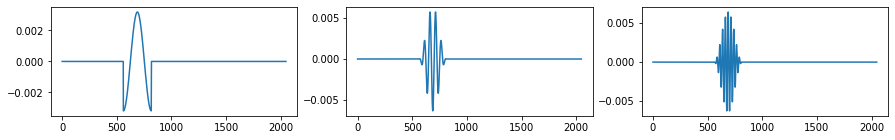

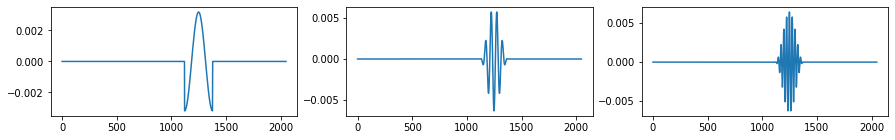

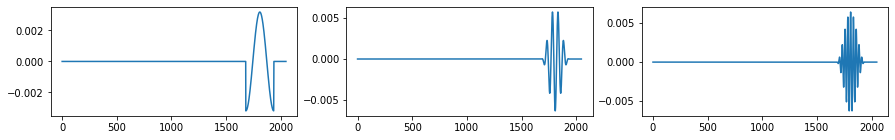

In [0]:
def plot_weights(index, weights=weights_sxx):
  plt.figure(figsize=(15, 2))
  plt.subplot(1, 3, 1)
  plt.plot(weights[index][0])
  plt.subplot(1, 3, 2)
  plt.plot(weights[index][5])
  plt.subplot(1, 3, 3)
  plt.plot(weights[index][10])
  plt.show()

for index in [0, 10, 20, 30]:
  plot_weights(index)

In [0]:
model.save("spectrogram-weights-256-15000-v4.h5")

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
!gsutil -h "Cache-control:public,max-age=86400" cp -a public-read spectrogram-*v4.h5 gs://muthanna.com/deepears

Copying file://spectrogram-weights-256-15000-v4.h5 [Content-Type=application/octet-stream]...
/
Operation completed over 1 objects/266.1 MiB.                                    


In [0]:
!wget --no-check-certificate https://muthanna.com/deepears/note-samples-v6.zip
!rm -rf samples
!unzip -q note-samples-v6.zip
!ls -l samples | head

--2020-03-02 16:08:33--  https://muthanna.com/deepears/note-samples-v6.zip
Resolving muthanna.com (muthanna.com)... 35.244.227.152
Connecting to muthanna.com (muthanna.com)|35.244.227.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 412675997 (394M) [application/zip]
Saving to: ‘note-samples-v6.zip’

note-samples-v6.zip 100%[===================>] 393.56M   108MB/s    in 4.2s    

2020-03-02 16:08:37 (94.5 MB/s) - ‘note-samples-v6.zip’ saved [412675997/412675997]

total 621888
-rw-r--r-- 1 root root 29150 Feb 24 22:20 note-A2-P16-110.000-S0-V0.45-reject-attack.wav
-rw-r--r-- 1 root root 29150 Feb 24 22:20 note-A2-P16-110.000-S0-V0.45-reject-decay.wav
-rw-r--r-- 1 root root 29150 Feb 24 22:20 note-A2-P16-110.000-S0-V0.45-reject-sustain.wav
-rw-r--r-- 1 root root 29150 Feb 24 22:20 note-A2-P16-127.000-S17-V0.68-reject-attack.wav
-rw-r--r-- 1 root root 29150 Feb 24 22:20 note-A2-P16-127.000-S17-V0.68-reject-decay.wav
-rw-r--r-- 1 root root 29150 Feb 24 22:20 no

Spectrogram for samples/note-Gs3-P0-248.652-S41-V0.93-noreject-sustain.wav
Spectrogram for samples/note-G6-P0-1634.982-S67-V0.41-noreject-attack.wav
Spectrogram for samples/note-Ds4-P6-311.127-S0-V0.24-noreject-sustain.wav
Spectrogram for samples/note-A7-P24-3543.000-S23-V0.33-noreject-sustain.wav
Spectrogram for samples/note-Cs3-P0-194.591-S56-V0.62-noreject-attack.wav
Spectrogram for samples/note-Gs7-P66-3353.438-S31-V0.8-noreject-attack.wav
Spectrogram for samples/note-F7-P48-2833.826-S40-V0.95-reject-attack.wav
Spectrogram for samples/note-C7-P19-2149.005-S56-V0.75-noreject-attack.wav
Spectrogram for samples/note-Fs7-P11-3007.955-S48-V0.26-noreject-attack.wav
Spectrogram for samples/note-D7-P61-2349.318-S0-V0.86-noreject-decay.wav
Spectrogram for samples/note-Gs7-P78-3371.438-S49-V0.83-noreject-sustain.wav
Spectrogram for samples/note-C3-P26-149.813-S19-V0.79-noreject-attack.wav
Spectrogram for samples/note-Cs3-P19-154.591-S16-V0.84-noreject-sustain.wav
Spectrogram for samples/note

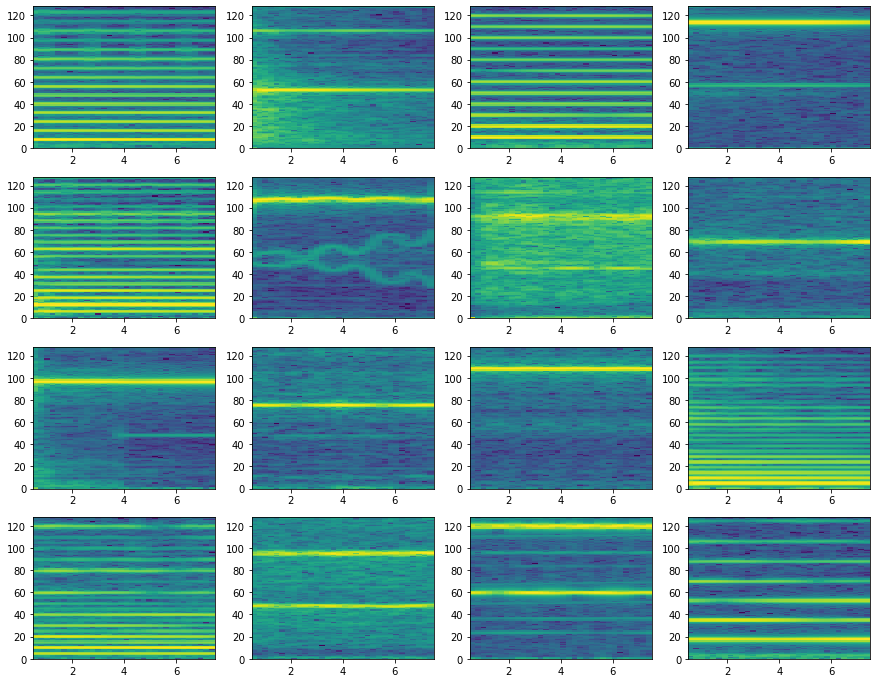

In [0]:
import os
from scipy.io import wavfile

def plot_file_spectrogram(file, resample_rate=8000, window_size=size, rows=rows, cols=cols):
  print("Spectrogram for", file)
  fs, data = wavfile.read(file)

  number_of_samples = round(len(data) * float(resample_rate) / fs)
  data = signal.resample(data, number_of_samples)

  # Calculate spectrogram using neural network
  nn_sxx = model.predict(np.reshape(data[:window_size], (1, window_size)))
  nn_sxx_graph = np.reshape(np.absolute(nn_sxx[0][rows * cols:] + 1j * nn_sxx[0][:rows * cols]), (rows, cols))
  plt.pcolormesh(t, f, np.log(nn_sxx_graph))

files = os.listdir('samples')
plt.figure(figsize=(15, 12))
for i in range(0, 16):
  plt.subplot(4, 4, i+1)
  plot_file_spectrogram('samples/'+files[i])

plt.show()
